# Analysis of jobs related to ocean
This document is used to investigate jobs that contain the word ocean within their exp_component field.


In [5]:
# import  epmt query
print('importing epmt_query')
import epmt_query as eq
# import matplot for better plotting functions
import sys
sys.path.insert(0,'/home/Ian.Laflotte/ians_py374/pip_experiment')   # required for plt to import
import matplotlib.pyplot as plt
import numpy as np
# import pandas. optional but helpful 'display.max_columns' arg shows all DataFrame columns when printing
print('importing pandas')
import pandas
pandas.set_option('display.max_columns', None)
#timing
import time


importing epmt_query
importing pandas


In [6]:
# retrieve all jobs corresponding to below criteria/tag(s)
# computationally heavy, but older jobs get grabbed faster, due to already being post-processed
job_num = 50000   #number of jobs grabbed
jobs_all = eq.get_jobs(limit=job_num, before=-14, 
                       fmt='dict')

In [7]:
#run through jobs and pull information from any that contain the word 'ocean' in their exp_component
#setup all variable names and dictionary paths
start = time.time()  #time how long the cell runs
tag_name = [] #list of tags with ocean in them
 #wording must be exact, except for ocean_other. Be careful about order of phrases that share more in common than just 'ocean_'
tag_groups =['ocean_scalar', 'ocean_monthly', 'ocean_month', 'ocean_daily', 'ocean_cobalt', 'ocean_annual', 'ocean_other']   #wording must be exact, except for ocean_other
rssmax_dict = {}   #dictionaries with keys for each tag we are looking at
node_dict = {}
generalized_rssmax = []   #every rssmax regardless of ocean tags. only things with 'generalized' are recording data from non ocean jobs.
exempt_jobs_rssmax = []   #all jobs pulled that do not contain 'ocean'
for dict_key in tag_groups:   #each tag group has its own key in variable dictonary
    rssmax_dict[dict_key] = []
    node_dict[dict_key] = []
    
#breaks down data into dictonaries
for job_instance in range(job_num):
    if jobs_all[job_instance].get('rssmax') is None or (
        len(jobs_all[job_instance].get('tags')) == 0):
        continue
        
    generalized_rssmax.append(jobs_all[job_instance].get('rssmax'))    
    tags = (jobs_all[job_instance].get('tags')['exp_component']) #every tag, regardless of 'ocean'
    for specific_group in tag_groups:      
        if tags.find(specific_group) >= 0 or tags.find('ocean') >= 0 and specific_group == 'ocean_other':   #find returns an integer if the exact word is in the string
            tag_name.append(tags)
            rssmax_dict[specific_group].append(jobs_all[job_instance].get('rssmax'))
            node_dict[specific_group].append(jobs_all[job_instance]['env_dict']['SLURM_NODELIST'])
            break
        if specific_group == 'ocean_other':   #if tag does not contain any key words
            exempt_jobs_rssmax.append(jobs_all[job_instance].get('rssmax'))
            
#print checks on data
tag_name_fin = sorted(set(tag_name)) #makes list of unique tags and organizes that list
print('jobs found = ',(len(tag_name)+1))
print('number of unique exp_component names = ', len(tag_name_fin)+1)
end = time.time()
print("time:",(end-start)/60)

jobs found =  18288
number of unique exp_component names =  152
time: 0.007955137888590496


### conversion and plotting
Below we take the data and run it through the long process of sorting it by node, averaging over each node, calculating error, and organizng by highest rssmax.

time: 0.10141083002090454


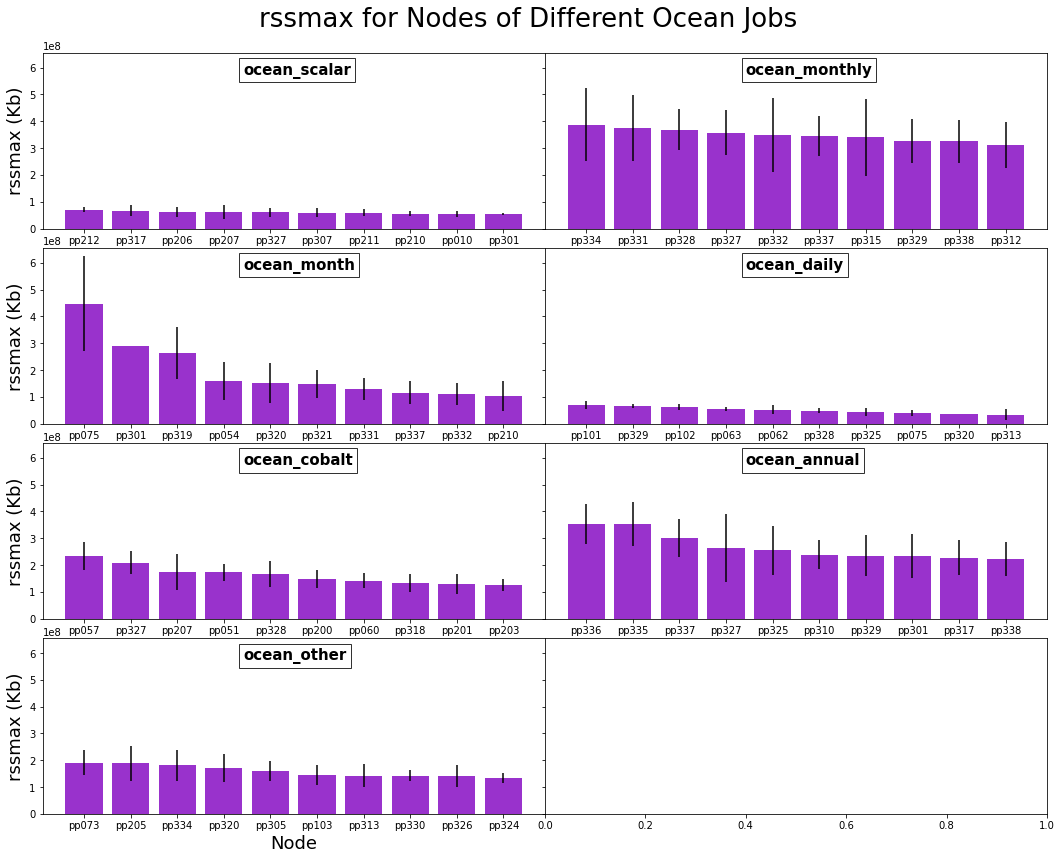

In [8]:
#This cell organizes the data and then plots it as a bar graph, with a maximum of 10 largest nodes
#sort the data and create a list of averages for rssmax
#creat the subplots for data to go into
start = time.time()
plot_num = 0 #tracks which subplot we are on
plt.style.use('default')
fig, ax = plt.subplots(nrows=round(len(tag_groups)/2+.1),ncols=2,figsize=(18,4*len(tag_groups)/2), sharex = 'none', sharey = 'all', gridspec_kw={'hspace': .11,'wspace':0})
ax =ax.ravel()   #this line is magic, touch it and the subplots fall apart

for specific_group in tag_groups:
    nodelist_fin = sorted(set(node_dict[specific_group]))   #sorted list of every unique node
    rssmax_fin = []
    standard_error = []
    counter = 0   #this counts which unique node in the list we are on
    temp_rssmax = []
    combo_rss_node = np.array(sorted(list(zip(node_dict[specific_group],rssmax_dict[specific_group]))))  #combines the lists into a 2d array with each entry as (node,rss)
    for aa in range(len(node_dict[specific_group])):
        if nodelist_fin[counter] == combo_rss_node[aa][0]:   #if the unique node currently in line = node of current rssmax value:
            temp_rssmax.append(rssmax_dict[specific_group][aa])
        else:   #triggers when new node reached
            counter += 1
            rssmax_fin.append(sum(temp_rssmax)/len(temp_rssmax))
            #error calculation
            standard_error.append(np.std(temp_rssmax)/(len(temp_rssmax))**.5)
            temp_rssmax = [rssmax_dict[specific_group][aa]]
        if aa == len(nodelist_fin)-1:   #covers final entry
            rssmax_fin.append(sum(temp_rssmax)/len(temp_rssmax))
            standard_error.append(np.std(temp_rssmax)/(len(temp_rssmax))**.5)
    #for larger data sets, we cutoff everything below the 10 highest averages, for plot clarity
    if len(nodelist_fin)> 10:
        temp_combo = np.array(sorted(zip(rssmax_fin,nodelist_fin,standard_error),reverse = True))
        nodelist_fin = []  
        rssmax_fin = []
        standard_error = []
        for cc in range(10):
            nodelist_fin.append(temp_combo[cc][1])
            rssmax_fin.append(float(temp_combo[cc][0]))
            standard_error.append(float(temp_combo[cc][2]))
            
    #plotting time    
    ax[plot_num].bar(nodelist_fin,rssmax_fin, yerr = standard_error, label = 'rss max', color = 'darkorchid')
    ax[plot_num].annotate(specific_group, xy=(0.4, 0.9), xycoords="axes fraction",color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    if (plot_num % 2) == 0:
        ax[plot_num].set_ylabel('rssmax (Kb)', size = 18)
    plot_num += 1
ax[plot_num-1].set_xlabel('Node', size = 18)
ax[plot_num-2].set_xlabel('Node', size = 18)
plt.suptitle('rssmax for Nodes of Different Ocean Jobs', y = .9, size =26, verticalalignment = 'bottom')
#plt.tight_layout()

#comment out savefig when running tests, in order to not overwrite good data
plt.savefig('analysis_plots/ocean_jobs/ocean_rssmax_nodes.pdf', bbox_inches='tight', format = 'pdf')

end = time.time()
print("time:",(end-start)/60)

# summarizing with histogram
Now we will take everything from above and condense it down into a single plot, allowing us to look at individual trends.

In [9]:
#take data from above plot and create a summarized plot
rssmax_avg = []
standard_error = []
full_ocean_rssmax = []
for specific_group in tag_groups:
    current_rssmax_list = rssmax_dict[specific_group]
    rssmax_avg.append(sum(current_rssmax_list)/len(current_rssmax_list))
    standard_error.append(np.std(current_rssmax_list)/(len(current_rssmax_list))**.5)
    full_ocean_rssmax.extend(current_rssmax_list)
total_ocean_rssmax_avg = sum(full_ocean_rssmax)/len(full_ocean_rssmax)
total_error = np.std(full_ocean_rssmax)/(len(full_ocean_rssmax))**.5
#generalized is all jobs grabbed, even if they do not have 'ocean' as a tag
generalized_rssmax_avg = sum(generalized_rssmax)/len(generalized_rssmax)
generalized_error = np.std(generalized_rssmax)/(len(generalized_rssmax))**.5
#jobs in generalized, but not in oceans
exempt_rssmax_avg = sum(exempt_jobs_rssmax)/len(exempt_jobs_rssmax)
exempt_error = np.std(exempt_jobs_rssmax)/(len(exempt_jobs_rssmax))**.5

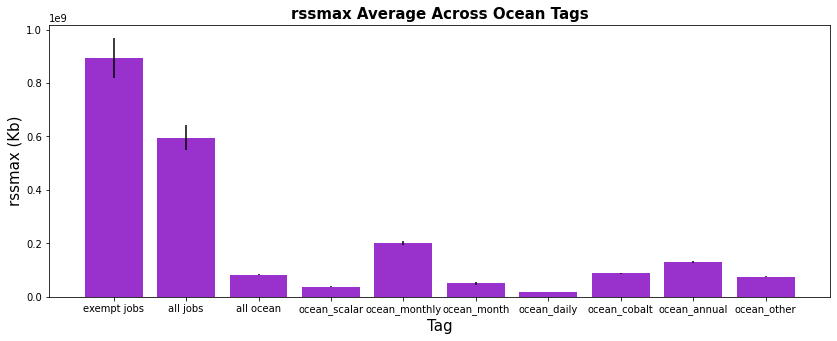

In [10]:
#plotting for overall averages
plt.figure(figsize = (14, 5))
plt.style.use('default')
plt.bar('exempt jobs',exempt_rssmax_avg, yerr = exempt_error, color = 'darkorchid')
plt.bar('all jobs',generalized_rssmax_avg, yerr = generalized_error, color = 'darkorchid')
plt.bar('all ocean',total_ocean_rssmax_avg, yerr = total_error, color = 'darkorchid')
plt.bar(tag_groups,rssmax_avg, yerr = standard_error, color = 'darkorchid')
#bells n whistles
plt.title('rssmax Average Across Ocean Tags', fontweight ='bold', fontsize = 15)
plt.ylabel('rssmax (Kb)', fontsize = 15)
plt.xlabel('Tag', fontsize = 15)
#plt.ylim(.9*min(rssmax_fin),1.1*max(rssmax_fin))
#plt.legend()
#cleanup
plt.tight_layout
plt.savefig('analysis_plots/ocean_jobs/barplot_rssmax_avg.pdf', bbox_inches='tight', format = 'pdf')
plt.show()


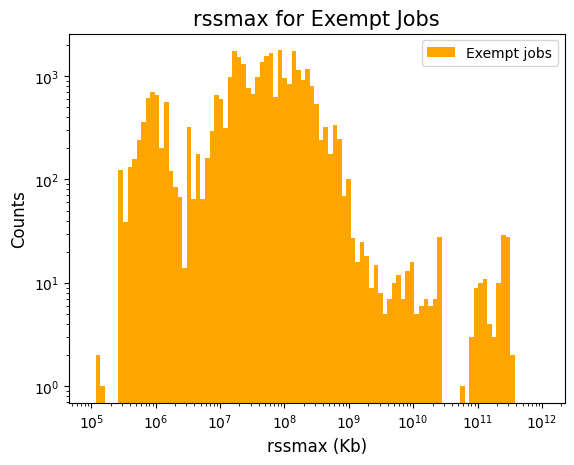

In [11]:
plt.hist(exempt_jobs_rssmax, bins = np.logspace(np.log10(1e5),np.log10(1e12), 100), range = (0,4e11), log = True, color ='orange', label = 'Exempt jobs')
#plt.hist(generalized_rssmax, bins = 100, range = (0,4e11), log = True, color ='brown')
#plt.hist(full_ocean_rssmax, bins = 1000, range = (0,4e11), log = True, color ='blue')
plt.legend()
plt.xscale('log')
plt.ylabel('Counts', fontsize = 12)
plt.xlabel('rssmax (Kb)', fontsize = 12)
plt.title('rssmax for Exempt Jobs', fontsize = 15)

plt.savefig('analysis_plots/ocean_jobs/hist_exempt_rssmax.pdf', bbox_inches='tight', format = 'pdf')

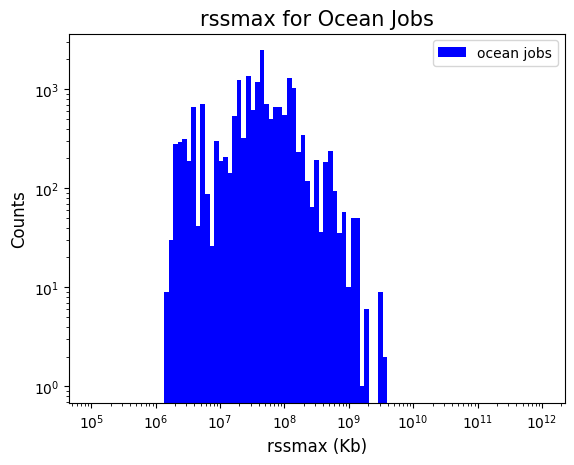

In [12]:
#plt.hist(exempt_jobs_rssmax, bins = 100, range = (0,4e11), log = True, color ='orange')
#plt.hist(generalized_rssmax, bins = 100, range = (0,4e11), log = True, color ='brown')
plt.hist(full_ocean_rssmax, bins = np.logspace(np.log10(1e5),np.log10(1e12), 100), range = (0,4e9), log = True, color ='blue', label = 'ocean jobs')
plt.legend()
plt.ylabel('Counts', fontsize = 12)
plt.xlabel('rssmax (Kb)', fontsize = 12)
plt.xscale('log')
plt.title('rssmax for Ocean Jobs', fontsize = 15)

plt.savefig('analysis_plots/ocean_jobs/hist_ocean_rssmax.pdf', bbox_inches='tight', format = 'pdf')

In [13]:
###
### Plot comparing duration of ocean vs others for sanity check
###
#breaks down data into dictonaries
generalized_duration = []
exempt_duration = []
ocean_duration = []
for job_instance in range(job_num):
    if jobs_all[job_instance].get('duration') is None or (
        len(jobs_all[job_instance].get('tags')) == 0):
        continue
    temp_duration = jobs_all[job_instance].get('duration')
    generalized_duration.append(temp_duration)    
    tags = (jobs_all[job_instance].get('tags')['exp_component']) #every tag, regardless of 'ocean'
    if tags.find('ocean') >= 0:
        ocean_duration.append(temp_duration)
    else:
        exempt_duration.append(temp_duration)
gen_dur_avg = sum(generalized_duration)/len(generalized_duration)
gen_dur_error = np.std(generalized_duration)/(len(generalized_duration))**.5
exempt_dur_avg = sum(exempt_duration)/len(exempt_duration)
exempt_dur_error = np.std(exempt_duration)/(len(exempt_duration))**.5
ocean_dur_avg = sum(ocean_duration)/len(ocean_duration)
ocean_dur_error = np.std(ocean_duration)/(len(ocean_duration))**.5

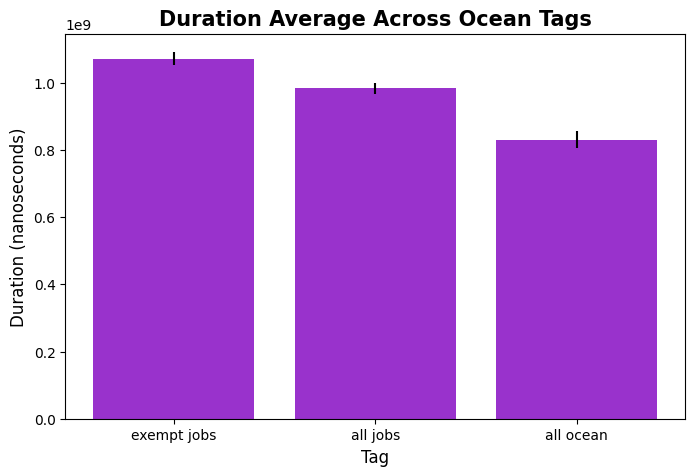

In [14]:
#make plot of duration
#plotting for overall averages
plt.figure(figsize = (8, 5))
plt.style.use('default')
plt.bar('exempt jobs',exempt_dur_avg, yerr = exempt_dur_error, color = 'darkorchid')
plt.bar('all jobs',gen_dur_avg, yerr = gen_dur_error, color = 'darkorchid')
plt.bar('all ocean',ocean_dur_avg, yerr = ocean_dur_error, color = 'darkorchid')
#bells n whistles
plt.title('Duration Average Across Ocean Tags', fontweight ='bold', fontsize = 15)
plt.ylabel('Duration (nanoseconds)', fontsize = 12)
plt.xlabel('Tag', fontsize = 12)
#plt.ylim(.9*min(rssmax_fin),1.1*max(rssmax_fin))
#plt.legend()
#cleanup
plt.tight_layout
plt.savefig('analysis_plots/ocean_jobs/bar_duration_alljobs.pdf', bbox_inches='tight', format = 'pdf')
plt.show()


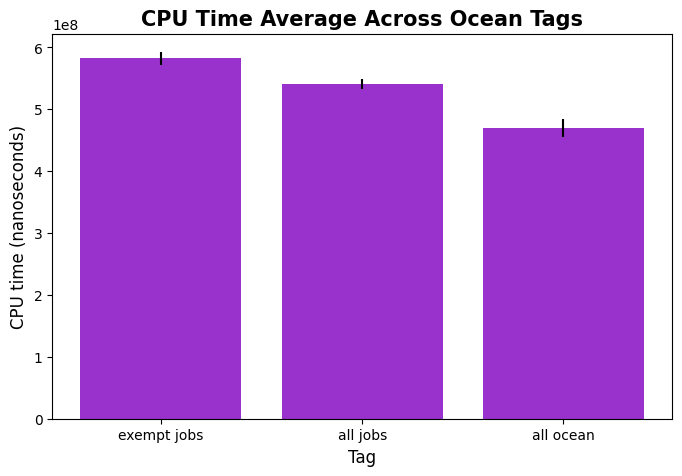

In [15]:
###
### Plot comparing duration of ocean vs others for sanity check
###
#breaks down data into dictonaries
generalized_cpu = []
exempt_cpu = []
ocean_cpu = []
for job_instance in range(job_num):
    if jobs_all[job_instance].get('cpu_time') is None or (
        len(jobs_all[job_instance].get('tags')) == 0):
        continue
    temp_cpu = jobs_all[job_instance].get('cpu_time')
    generalized_cpu.append(temp_cpu)    
    tags = (jobs_all[job_instance].get('tags')['exp_component']) #every tag, regardless of 'ocean'
    if tags.find('ocean') >= 0:
        ocean_cpu.append(temp_cpu)
    else:
        exempt_cpu.append(temp_cpu)
gen_cpu_avg = sum(generalized_cpu)/len(generalized_cpu)
gen_cpu_error = np.std(generalized_cpu)/(len(generalized_cpu))**.5
exempt_cpu_avg = sum(exempt_cpu)/len(exempt_cpu)
exempt_cpu_error = np.std(exempt_cpu)/(len(exempt_cpu))**.5
ocean_cpu_avg = sum(ocean_cpu)/len(ocean_cpu)
ocean_cpu_error = np.std(ocean_cpu)/(len(ocean_cpu))**.5

#make plot of duration
#plotting for overall averages
plt.figure(figsize = (8, 5))
plt.style.use('default')
plt.bar('exempt jobs',exempt_cpu_avg, yerr = exempt_cpu_error, color = 'darkorchid')
plt.bar('all jobs',gen_cpu_avg, yerr = gen_cpu_error, color = 'darkorchid')
plt.bar('all ocean',ocean_cpu_avg, yerr = ocean_cpu_error, color = 'darkorchid')
#bells n whistles
plt.title('CPU Time Average Across Ocean Tags', fontweight ='bold', fontsize = 15)
plt.ylabel('CPU time (nanoseconds)', fontsize = 12)
plt.xlabel('Tag', fontsize = 12)
#plt.ylim(.9*min(rssmax_fin),1.1*max(rssmax_fin))
#plt.legend()
#cleanup
plt.tight_layout
plt.savefig('analysis_plots/ocean_jobs/bar_cputime_alljobs.pdf', bbox_inches='tight', format = 'pdf')
plt.show()

# 2D histograms
We will now compare rssmax and duration on the same histogram. once for ocean, once for exempt

/home/fms/local/epmt/4.9.2-centos-7/epmt-install/epmt/epmt:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


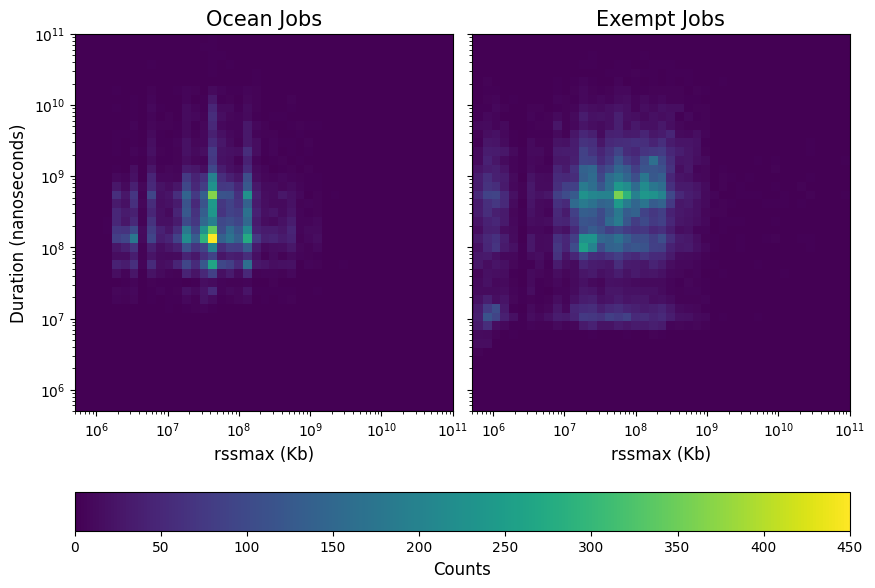

In [16]:
#2D hsitogram of duration and rssmax
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,7), sharex = 'all', sharey = 'all', gridspec_kw={'hspace': .11,'wspace':.05})
ax =ax.ravel()
#assign subplots to variable in order to merge colorbars
hist0 = ax[0].hist2d(x = full_ocean_rssmax,y=ocean_duration[0:len(full_ocean_rssmax)], bins = np.logspace(np.log10(1e5),np.log10(1e11), 50), vmax = 450)
hist1 = ax[1].hist2d(x = exempt_jobs_rssmax,y=exempt_duration[0:len(exempt_jobs_rssmax)], bins = np.logspace(np.log10(1e5),np.log10(1e11), 50), vmax = 450)
plt.xscale('log')
plt.yscale('log')
ax[0].set_xlabel('rssmax (Kb)',fontsize = 12)
ax[1].set_xlabel('rssmax (Kb)',fontsize = 12)
ax[0].set_ylabel('Duration (nanoseconds)',fontsize = 12)
plt.xlim(5e5,1e11)
plt.ylim(5e5,1e11)
cb = fig.colorbar(hist1[3], ax=ax, location='bottom')
cb.set_label(label = 'Counts',size = 12)
ax[0].set_title('Ocean Jobs', size = 15)
ax[1].set_title('Exempt Jobs',size = 15)
plt.tight_layout()

plt.savefig('analysis_plots/ocean_jobs/hist2d_rssmax_duration.pdf', bbox_inches='tight', format = 'pdf')


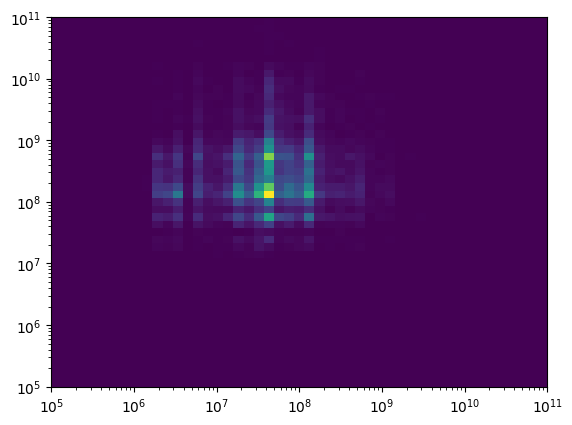

In [18]:
plt.hist2d(x = full_ocean_rssmax,y=ocean_duration[0:len(full_ocean_rssmax)], bins = np.logspace(np.log10(1e5),np.log10(1e11), 50), vmax = 450)
plt.xscale('log')
plt.yscale('log')